# 3.1. 线性回归

在机器学习的术语中，该数据集称为训练数据集（training data set）或训练集（training set）。每行数据（比如一次房屋交易相对应的数据）称为样本（sample）， 也可以称为数据点（data point）或数据样本（data instance）。我们把试图预测的目标（比如预测房屋价格）称为标签（label）或目标（target）。预测所依据的自变量（面积和房龄）称为特征（feature）或协变量（covariate）。

## 3.1.1. 线性回归的基本元素

### 3.1.1.1. 线性模型

仿射变换（affine transformation）的特点是通过加权和对特征进行线性变换（linear transformation），并通过偏置项来进行平移（translation）。

向量$\mathbf{x}$对应于单个数据样本的特征。用符号表示的矩阵$\mathbf{X} \in \mathbb{R}^{n \times d}$可以很方便地引用我们整个数据集的$n$个样本。其中，$\mathbf{X}$的每一行是一个样本，每一列是一种特征。

对于特征集合$\mathbf{X}$，预测值$\hat{\mathbf{y}} \in \mathbb{R}^n$可以通过矩阵-向量乘法表示为：
$${\hat{\mathbf{y}}} = \mathbf{X} \mathbf{w} + b$$

在开始寻找最好的*模型参数*（model parameters）$\mathbf{w}$和$b$之前，我们还需要两个东西：

（1）一种模型质量的度量方式；

（2）一种能够更新模型以提高模型预测质量的方法。

### 3.1.1.2. 损失函数

在我们开始考虑如何用模型*拟合*（fit）数据之前，我们需要确定一个拟合程度的度量。*损失函数*（loss function）能够量化目标的*实际*值与*预测*值之间的差距。通常我们会选择非负数作为损失，且数值越小表示损失越小，完美预测时的损失为0。回归问题中最常用的损失函数是平方误差函数。当样本$i$的预测值为$\hat{y}^{(i)}$，其相应的真实标签为$y^{(i)}$时，平方误差可以定义为以下公式：

$$l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2.$$

常数$\frac{1}{2}$不会带来本质的差别，但这样在形式上稍微简单一些（因为当我们对损失函数求导后常数系数为1）。

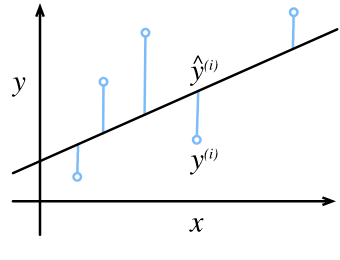

由于平方误差函数中的二次方项，估计值$\hat{y}^{(i)}$和观测值$y^{(i)}$之间较大的差异将导致更大的损失。为了度量模型在整个数据集上的质量，我们需计算在训练集$n$个样本上的损失均值（也等价于求和）。

$$L(\mathbf{w}, b) =\frac{1}{n}\sum_{i=1}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

在训练模型时，我们希望寻找一组参数（$\mathbf{w}^*, b^*$），这组参数能最小化在所有训练样本上的总损失。如下式：

$$\mathbf{w}^*, b^* = \operatorname*{argmin}_{\mathbf{w}, b}\  L(\mathbf{w}, b).$$

### 3.1.1.3. 解析解

线性回归刚好是一个很简单的优化问题。与我们将在本书中所讲到的其他大部分模型不同，线性回归的解可以用一个公式简单地表达出来，这类解叫作解析解（analytical solution）。


### 3.1.1.4. 随机梯度下降

即使在我们无法得到解析解的情况下，我们仍然可以有效地训练模型。

梯度下降最简单的用法是计算损失函数（数据集中所有样本的损失均值）关于模型参数的导数（在这里也可以称为梯度）。但实际中的执行可能会非常慢：因为在每一次更新参数之前，我们必须遍历整个数据集。因此，我们通常会在每次需要计算更新的时候随机抽取一小批样本，这种变体叫做小批量随机梯度下降（minibatch stochastic gradient descent）。

批量大小和学习率的值通常是手动预先指定，而不是通过模型训练得到的。这些可以调整但不在训练过程中更新的参数称为超参数（hyperparameter）。调参（hyperparameter tuning）是选择超参数的过程。超参数通常是我们根据训练迭代结果来调整的，而训练迭代结果是在独立的验证数据集（validation dataset）上评估得到的。

线性回归恰好是一个在整个域中只有一个最小值的学习问题。但是对于像深度神经网络这样复杂的模型来说，损失平面上通常包含多个最小值。深度学习实践者很少会去花费大力气寻找这样一组参数，使得在训练集上的损失达到最小。事实上，更难做到的是找到一组参数，这组参数能够在我们从未见过的数据上实现较低的损失，这一挑战被称为泛化（generalization）。


### 3.1.1.5. 用模型进行预测

给定特征估计目标的过程通常称为预测（prediction）或推断（inference）。

## 3.1.2. 矢量化加速

In [1]:
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

In [2]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

In [3]:
class Timer:  
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [4]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.11967 sec'

In [5]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00000 sec'

## 3.1.3. 正态分布与平方损失

In [6]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

In [7]:
import matplotlib.pyplot as plt

In [8]:
# 再次使用numpy进行可视化
x = np.arange(-7, 7, 0.01)

# 均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]
# d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
#          ylabel='p(x)', figsize=(4.5, 2.5),
#          legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

## 3.1.4. 从线性回归到深度网络

到目前为止，我们只谈论了线性模型。尽管神经网络涵盖了更多更为丰富的模型，我们依然可以用描述神经网络的方式来描述线性模型，从而把线性模型看作一个神经网络。首先，我们用“层”符号来重写这个模型。

### 3.1.4.1. 神经网络图

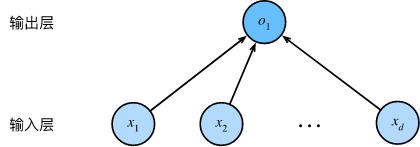

在所示的神经网络中，输入为$x_1, \ldots, x_d$，因此输入层中的*输入数*（或称为*特征维度*，feature dimensionality）为$d$。网络的输出为$o_1$，因此输出层中的*输出数*是1。需要注意的是，输入值都是已经给定的，并且只有一个*计算*神经元。由于模型重点在发生计算的地方，所以通常我们在计算层数时不考虑输入层。也就是说，神经网络的*层数*为1。我们可以将线性回归模型视为仅由单个人工神经元组成的神经网络，或称为单层神经网络。

对于线性回归，每个输入都与每个输出（在本例中只有一个输出）相连，我们将这种变换称为*全连接层*（fully-connected layer）或称为*稠密层*（dense layer）。下一章将详细讨论由这些层组成的网络。

# 3.2. 线性回归的从零开始实现

## 3.2.1. 生成数据集

In [9]:
import random
import torch

在下面的代码中，我们生成一个包含1000个样本的数据集，每个样本包含从标准正态分布中采样的2个特征。我们的合成数据集是一个矩阵$\mathbf{X}\in \mathbb{R}^{1000 \times 2}$。

(**我们使用线性模型参数$\mathbf{w} = [2, -3.4]^\top$、$b = 4.2$
和噪声项$\epsilon$生成数据集及其标签：
$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$
**)

$\epsilon$可以视为模型预测和标签时的潜在观测误差。在这里我们认为标准假设成立，即$\epsilon$服从均值为0的正态分布。为了简化问题，我们将标准差设为0.01。下面的代码生成合成数据集。

In [10]:
def synthetic_data(w, b, num_examples): 
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w))) # torch.normal的arg分别是mean, std和生成矩阵的size
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape) # 给y加一个潜在观测误差
    return X, y.reshape((-1, 1))

In [11]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
features.shape

torch.Size([1000, 2])

注意，features中的每一行都包含一个二维数据样本，labels中的每一行都包含一维标签值（一个标量）。

In [12]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([0.0935, 0.4796]) 
label: tensor([2.7481])


通过生成第二个特征`features[:, 1]`和`labels`的散点图，可以直观观察到两者之间的线性关系。


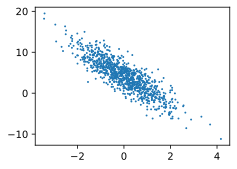

In [13]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

## 3.2.2. 读取数据集

回想一下，训练模型时要对数据集进行遍历，每次抽取一小批量样本，并使用它们来更新我们的模型。由于这个过程是训练机器学习算法的基础，所以有必要定义一个函数，该函数能打乱数据集中的样本并以小批量方式获取数据。

In [14]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

我们直观感受一下小批量运算：读取第一个小批量数据样本并打印。每个批量的特征维度显示批量大小和输入特征数。同样的，批量的标签形状与batch_size相等。(10个)

In [15]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    print(X.shape)
    break

tensor([[ 1.3590e+00, -4.6761e-01],
        [-4.4465e-02,  1.9359e+00],
        [ 5.3101e-01, -5.1842e-01],
        [ 8.8356e-01,  2.2118e+00],
        [ 6.6960e-01, -2.0046e+00],
        [-2.0366e+00,  9.9821e-01],
        [-9.5114e-01, -1.1842e+00],
        [ 1.3143e-03,  2.2349e-01],
        [-2.2426e+00, -8.5998e-01],
        [-5.4153e-01, -1.4820e+00]]) 
 tensor([[ 8.5245],
        [-2.4619],
        [ 7.0164],
        [-1.5562],
        [12.3356],
        [-3.2620],
        [ 6.3319],
        [ 3.4535],
        [ 2.6371],
        [ 8.1612]])
torch.Size([10, 2])


当我们运行迭代时，我们会连续地获得不同的小批量，直至遍历完整个数据集。

## 3.2.3. 初始化模型参数

在下面的代码中，我们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重，并将偏置初始化为0。

In [16]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

## 3.2.4. 定义模型

In [17]:
def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

## 3.2.5. 定义损失函数

在实现中，我们需要将真实值y的形状转换为和预测值y_hat的形状相同。

In [18]:
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## 3.2.6. 定义优化算法

在每一步中，使用从数据集中随机抽取的一个小批量，然后根据参数计算损失的梯度。接下来，朝着减少损失的方向更新我们的参数。下面的函数实现小批量随机梯度下降更新。该函数接受模型参数集合、学习速率和批量大小作为输入。每一步更新的大小由学习速率lr决定。因为我们计算的损失是一个批量样本的总和，所以我们用批量大小（batch_size）来规范化步长，这样步长大小就不会取决于我们对批量大小的选择。

In [19]:
def sgd(params, lr, batch_size): 
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()
# torch.no_grad()： 一个上下文管理器，被该语句 wrap起来的部分将不会track梯度
# param.grad.zero_()： 手动将梯度设置成0 ，在下一次计算梯度的时候就不会和上一次相关了

## 3.2.7. 训练

在每个迭代周期（epoch）中，我们使用data_iter函数遍历整个数据集，并将训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。这里的迭代周期个数num_epochs和学习率lr都是超参数，分别设为3和0.03。

In [21]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.000053
epoch 2, loss 0.000053
epoch 3, loss 0.000054


In [22]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0004, -0.0003], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0004], grad_fn=<RsubBackward1>)


# 3.3. 线性回归的简洁实现

## 3.3.1. 生成数据集

In [23]:
# !pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l

In [24]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

## 3.3.2. 读取数据集

我们可以调用框架中现有的API来读取数据。我们将features和labels作为API的参数传递，并通过数据迭代器指定batch_size。此外，布尔值is_train表示是否希望数据迭代器对象在每个迭代周期内打乱数据。

In [25]:
def load_array(data_arrays, batch_size, is_train=True):  
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

为了验证是否正常工作，让我们读取并打印第一个小批量样本。这里我们使用iter构造Python迭代器，并使用next从迭代器中获取第一项。

In [26]:
next(iter(data_iter))

[tensor([[ 0.3594, -2.5291],
         [ 0.3879,  0.5123],
         [-0.8438, -1.0565],
         [-0.0220,  1.6967],
         [ 0.1599,  2.1435],
         [-1.3648,  0.3831],
         [ 0.9405, -0.4165],
         [-0.9437, -0.7895],
         [ 1.4056,  0.2930],
         [-0.3163, -0.5815]]),
 tensor([[13.5167],
         [ 3.2151],
         [ 6.1044],
         [-1.6218],
         [-2.7713],
         [ 0.1718],
         [ 7.5086],
         [ 4.9730],
         [ 6.0103],
         [ 5.5496]])]

## 3.3.3. 定义模型

我们首先定义一个模型变量net，它是一个Sequential类的实例。Sequential类将多个层串联在一起。当给定输入数据时，Sequential实例将数据传入到第一层，然后将第一层的输出作为第二层的输入，以此类推。在下面的例子中，我们的模型只包含一个层，因此实际上不需要Sequential。但是由于以后几乎所有的模型都是多层的，在这里使用Sequential会让你熟悉“标准的流水线”。

In [27]:
# nn是神经网络的缩写
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

## 3.3.4. 初始化模型参数

我们通过net[0]选择网络中的第一个图层，然后使用weight.data和bias.data方法访问参数。我们还可以使用替换方法normal_和fill_来重写参数值

In [28]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

## 3.3.5. 定义损失函数

In [29]:
loss = nn.MSELoss()

## 3.3.6. 定义优化算法

小批量随机梯度下降算法是一种优化神经网络的标准工具，PyTorch在optim模块中实现了该算法的许多变种。当我们实例化一个SGD实例时，我们要指定优化的参数（可通过net.parameters()从我们的模型中获得）以及优化算法所需的超参数字典。小批量随机梯度下降只需要设置lr值，这里设置为0.03。

In [30]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

## 3.3.7. 训练

In [31]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        l.backward() # pytorch已经求和了
        trainer.step() # 执行一次梯度下降
        trainer.zero_grad() # 必须清零梯度,否则会累加
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000418
epoch 2, loss 0.000103
epoch 3, loss 0.000103


In [32]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([ 0.0006, -0.0004])
b的估计误差： tensor([0.0006])


# 3.4. softmax回归

## 3.4.1. 分类问题

独热编码是一个向量，它的分量和类别一样多。类别对应的分量设置为1，其他所有分量设置为0。 

## 3.4.2. 网络架构

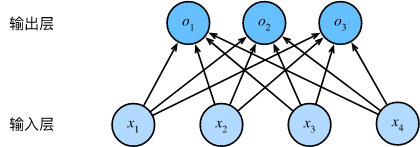

## 3.4.3. 全连接层的参数开销

## 3.4.4. softmax运算

softmax函数将未规范化的预测变换为非负并且总和为1，同时要求模型保持可导。我们首先对每个未规范化的预测求幂，这样可以确保输出非负。为了确保最终输出的总和为1，我们再对每个求幂后的结果除以它们的总和。如下式：

$$\hat{\mathbf{y}} = \mathrm{softmax}(\mathbf{o})\quad \text{其中}\quad \hat{y}_j = \frac{\exp(o_j)}{\sum_k \exp(o_k)}$$

这里，对于所有的$j$总有$0 \leq \hat{y}_j \leq 1$。因此，$\hat{\mathbf{y}}$可以视为一个正确的概率分布。softmax运算不会改变未规范化的预测$\mathbf{o}$之间的顺序，只会确定分配给每个类别的概率。因此，在预测过程中，我们仍然可以用下式来选择最有可能的类别。

$$
\operatorname*{argmax}_j \hat y_j = \operatorname*{argmax}_j o_j.
$$

尽管softmax是一个非线性函数，但softmax回归的输出仍然由输入特征的仿射变换决定。因此，softmax回归是一个*线性模型*（linear model）。


## 3.4.5. 小批量样本的矢量化

## 3.4.6. 损失函数

### 3.4.6.1. 对数似然

### 3.4.6.2. softmax及其导数

### 3.4.6.3. 交叉熵损失

## 3.4.7. 信息论基础

### 3.4.7.1. 熵

### 3.4.7.2. 信息量

### 3.4.7.3. 重新审视交叉熵

### 3.4.8. 模型预测和评估

# 3.5. 图像分类数据集

In [33]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

## 3.5.1. 读取数据集

In [34]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0到1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)
# transform = trans 将图片转为tensor

Fashion-MNIST由10个类别的图像组成，每个类别由训练数据集（train dataset）中的6000张图像和测试数据集（test dataset）中的1000张图像组成。因此，训练集和测试集分别包含60000和10000张图像。测试数据集不会用于训练，只用于评估模型性能。

In [35]:
len(mnist_train), len(mnist_test)

(60000, 10000)

每个输入图像的高度和宽度均为28像素。数据集由灰度图像组成，其通道数为1。为了简洁起见，本书将高度$h$像素、宽度$w$像素图像的形状记为$h \times w$或（$h$, $w$）。

In [36]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [37]:
def get_fashion_mnist_labels(labels):  
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [38]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

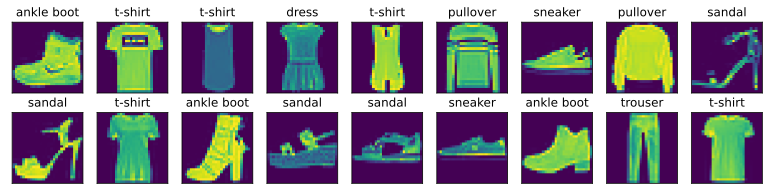

In [39]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

## 3.5.2. 读取小批量

为了使我们在读取训练集和测试集时更容易，我们使用内置的数据迭代器，而不是从零开始创建。回顾一下，在每次迭代中，数据加载器每次都会读取一小批量数据，大小为batch_size。通过内置数据迭代器，我们可以随机打乱了所有样本，从而无偏见地读取小批量。

In [40]:
batch_size = 256

def get_dataloader_workers():
    """使用4个进程来读取数据"""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())

In [41]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'4.33 sec'

## 3.5.3. 整合所有组件

In [42]:
def load_data_fashion_mnist(batch_size, resize=None):  
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [43]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64) # 区别是shuffle
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


# 3.6. softmax回归的从零开始实现

In [44]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## 3.6.1. 初始化模型参数

In [45]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

## 3.6.2. 定义softmax操作

In [46]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [47]:
X

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [48]:
X.sum(0, keepdim=True).shape

torch.Size([1, 3])

In [49]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

In [50]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.5494, 0.1791, 0.0310, 0.1127, 0.1278],
         [0.2627, 0.0124, 0.6734, 0.0100, 0.0415]]),
 tensor([1., 1.]))

In [51]:
X

tensor([[ 0.6679, -0.4527, -2.2055, -0.9164, -0.7907],
        [ 2.5660, -0.4900,  3.5074, -0.6995,  0.7218]])

## 3.6.3. 定义模型

In [52]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

## 3.6.4. 定义损失函数

下面，我们创建一个数据样本y_hat，其中包含2个样本在3个类别的预测概率，以及它们对应的标签y。有了y，我们知道在第一个样本中，第一类是正确的预测；而在第二个样本中，第三类是正确的预测。然后使用y作为y_hat中概率的索引，我们选择第一个样本中第一个类的概率和第二个样本中第三个类的概率。

In [53]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [54]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

## 3.6.5. 分类精度

首先，如果y_hat是矩阵，那么假定第二个维度存储每个类的预测分数。我们使用argmax获得每行中最大元素的索引来获得预测类别。然后我们将预测类别与真实y元素进行比较。由于等式运算符“==”对数据类型很敏感，因此我们将y_hat的数据类型转换为与y的数据类型一致。 结果是一个包含0（错）和1（对）的张量。最后，我们求和会得到正确预测的数量。

In [56]:
def accuracy(y_hat, y): 
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [57]:
accuracy(y_hat, y) / len(y)

0.5

这里定义一个实用程序类Accumulator，用于对多个变量进行累加。在上面的evaluate_accuracy函数中，我们在Accumulator实例中创建了2个变量，分别用于存储正确预测的数量和预测的总数量。当我们遍历数据集时，两者都将随着时间的推移而累加。



In [59]:
class Accumulator: 
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [60]:
def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [61]:
evaluate_accuracy(net, test_iter)

0.0906

## 3.6.6. 训练

In [62]:
def train_epoch_ch3(net, train_iter, loss, updater): 
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [63]:
class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [64]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [65]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

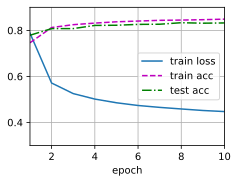

In [66]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

## 3.6.7. 预测

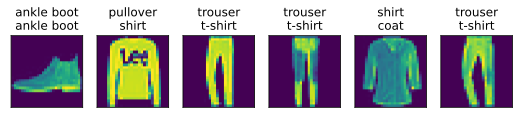

In [70]:
def predict_ch3(net, test_iter, n=6): 
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

# 3.7. softmax回归的简洁实现

In [71]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## 3.7.1. 初始化模型参数

In [72]:
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

## 3.7.2. 重新审视Softmax的实现

In [73]:
loss = nn.CrossEntropyLoss(reduction='none')

## 3.7.3. 优化算法

In [74]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

## 3.7.4. 训练

In [75]:
# !pip uninstall matplotlib -y
# !pip install matplotlib==3.0.0

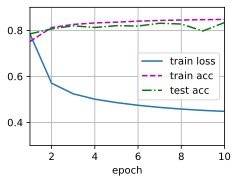

In [76]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)